In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Point this to your CSV:
csv_path = r"C:\Users\User\Documents\Thesis\SUS_evaluation\system_feedback.csv"

# Make plots show inside the notebook
%matplotlib inline
plt.rcParams["figure.figsize"] = (9, 5)
plt.rcParams["axes.grid"] = True


In [10]:
df = pd.read_csv(csv_path)
display(df.head())
print(f"Rows: {len(df)}, Columns: {list(df.columns)}")


,I think that I would like to use this system frequently,I found the system unnecessarily complex,I thought the system was easy to use,I think that I would need the support of a technical person to be able to use this system,I found the various functions in this system were well integrated,I thought there was too much inconsistency in this system,I would imagine that most people would learn to use this system very quickly,I found the system very cumbersome to use,I felt very confident using the system,I needed to learn a lot of things before I could get going with this system
0,4,2,3,2,4,3,4,3,5,2
1,5,1,4,1,5,1,5,2,5,2
2,4,2,4,2,4,1,5,2,5,3
3,3,1,3,1,4,1,4,3,5,2
4,4,2,5,3,5,3,4,3,3,1


Rows: 30, Columns: ['I think that I would like to use this system frequently', 'I found the system unnecessarily complex', 'I thought the system was easy to use', 'I think that I would need the support of a technical person to be able to use this system', 'I found the various functions in this system were well integrated', 'I thought there was too much inconsistency in this system', 'I would imagine that most people would learn to use this system very quickly', 'I found the system very cumbersome to use', 'I felt very confident using the system', 'I needed to learn a lot of things before I could get going with this system']


In [11]:
SUS_TEXTS = [
    "I think that I would like to use this system frequently",
    "I found the system unnecessarily complex",
    "I thought the system was easy to use",
    "I think that I would need the support of a technical person to be able to use this system",
    "I found the various functions in this system were well integrated",
    "I thought there was too much inconsistency in this system",
    "I would imagine that most people would learn to use this system very quickly",
    "I found the system very cumbersome to use",
    "I felt very confident using the system",
    "I needed to learn a lot of things before I could get going with this system",
]

def detect_sus_columns(df: pd.DataFrame):
    # Prefer full texts
    cols = [c for c in SUS_TEXTS if c in df.columns]
    if len(cols) == 10:
        return cols
    # Try Q1..Q10
    qcols = [f"Q{i}" for i in range(1, 11) if f"Q{i}" in df.columns]
    if len(qcols) == 10:
        return qcols
    # Fallback: first 10 numeric columns
    num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    if len(num_cols) >= 10:
        return num_cols[:10]
    raise ValueError("Could not find 10 SUS columns (need Q1..Q10 or SUS texts).")

qcols = detect_sus_columns(df)
qcols


['I think that I would like to use this system frequently',
 'I found the system unnecessarily complex',
 'I thought the system was easy to use',
 'I think that I would need the support of a technical person to be able to use this system',
 'I found the various functions in this system were well integrated',
 'I thought there was too much inconsistency in this system',
 'I would imagine that most people would learn to use this system very quickly',
 'I found the system very cumbersome to use',
 'I felt very confident using the system',
 'I needed to learn a lot of things before I could get going with this system']

In [13]:
# Ensure numeric 1..5
df[qcols] = df[qcols].apply(pd.to_numeric, errors="coerce").clip(1, 5)

# Compute SUS
odd_idx  = [0, 2, 4, 6, 8]   # 0-based indices for items 1,3,5,7,9
even_idx = [1, 3, 5, 7, 9]   # items 2,4,6,8,10

odd_sum  = df[qcols].iloc[:, odd_idx].sub(1).sum(axis=1)
even_sum = (5 - df[qcols].iloc[:, even_idx]).sum(axis=1)
df["SUS_Score"] = (odd_sum + even_sum) * 2.5

# Quick summary
summary = {
    "N": len(df),
    "Mean_SUS": df["SUS_Score"].mean(),
    "Median_SUS": df["SUS_Score"].median(),
    "Std_SUS": df["SUS_Score"].std(ddof=1) if len(df) > 1 else 0.0,
    "Min_SUS": df["SUS_Score"].min(),
    "Max_SUS": df["SUS_Score"].max(),
}
summary


{'N': 30,
 'Mean_SUS': 77.41666666666667,
 'Median_SUS': 77.5,
 'Std_SUS': 6.710880682908159,
 'Min_SUS': 67.5,
 'Max_SUS': 92.5}

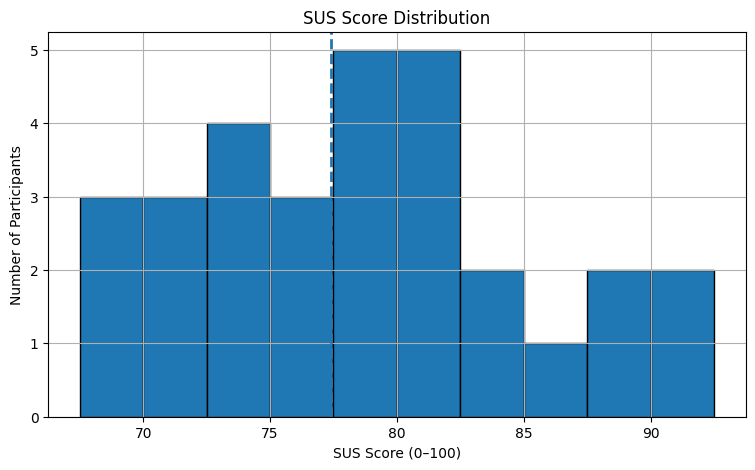

In [14]:
plt.figure()
plt.hist(df["SUS_Score"], bins=10, edgecolor="black")
plt.axvline(df["SUS_Score"].mean(), linestyle="--", linewidth=2)
plt.title("SUS Score Distribution")
plt.xlabel("SUS Score (0–100)")
plt.ylabel("Number of Participants")
plt.show()


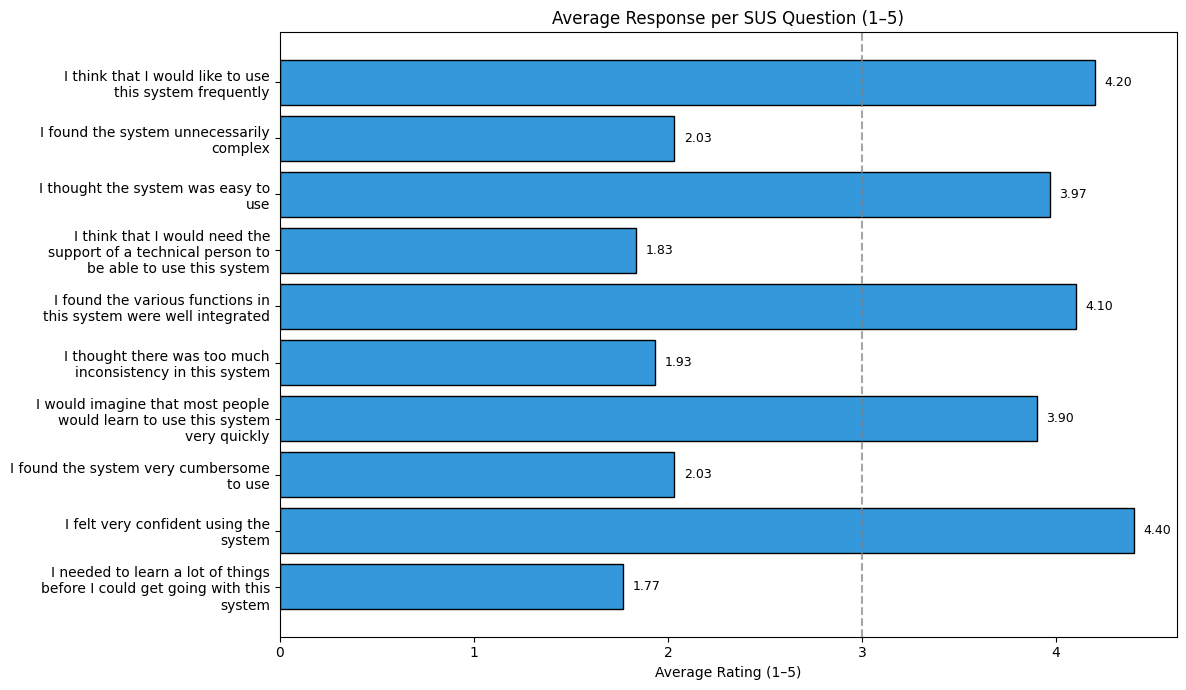

In [15]:
import textwrap
import matplotlib.pyplot as plt

means = df[qcols].mean()

# Labels
if all(c.startswith("Q") for c in qcols):
    short_labels = {
        1: "Use frequently (+)",
        2: "Unnecessarily complex (-)",
        3: "Easy to use (+)",
        4: "Need tech support (-)",
        5: "Well integrated (+)",
        6: "Too inconsistent (-)",
        7: "Learn quickly (+)",
        8: "Cumbersome (-)",
        9: "Confident (+)",
        10:"Needed to learn a lot (-)"
    }
    labels = [short_labels[i] for i in range(1, 11)]
else:
    labels = [textwrap.fill(c, width=34) for c in qcols]

# Plot
fig, ax = plt.subplots(figsize=(12, 7))
ax.barh(range(len(means)), means.values, edgecolor="black", color="#3498db")

# Labels and style
ax.set_yticks(range(len(means)))
ax.set_yticklabels(labels)
ax.invert_yaxis()
ax.set_xlabel("Average Rating (1–5)")
ax.set_title("Average Response per SUS Question (1–5)")

# Keep only one neutral reference line
ax.axvline(3, linestyle="--", color="gray", alpha=0.7)

# Remove all background grid lines
ax.grid(False)

# Annotate scores on bars
for i, v in enumerate(means.values):
    ax.text(v + 0.05, i, f"{v:.2f}", va="center", fontsize=9)

plt.subplots_adjust(left=0.35)
plt.tight_layout()
plt.show()


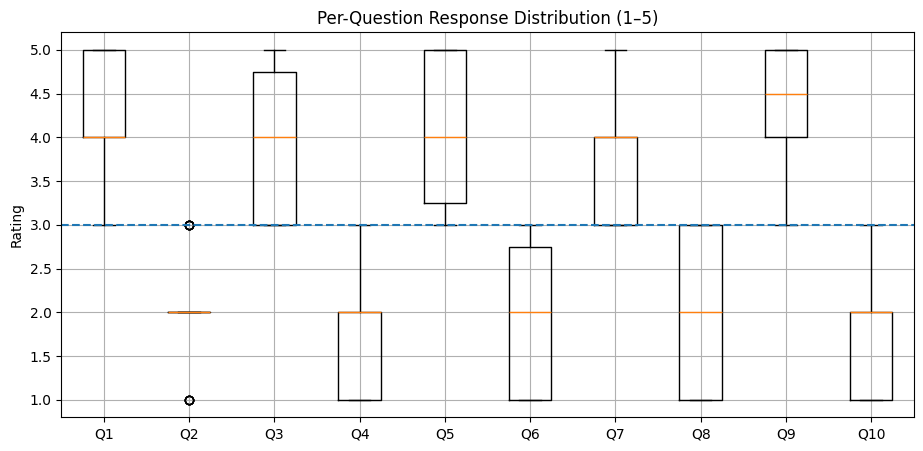

In [33]:
plt.figure(figsize=(11,5))
plt.boxplot([df[c].values for c in qcols], labels=[f"Q{i}" for i in range(1,11)])
plt.axhline(3, linestyle="--")
plt.title("Per-Question Response Distribution (1–5)")
plt.ylabel("Rating")
plt.show()


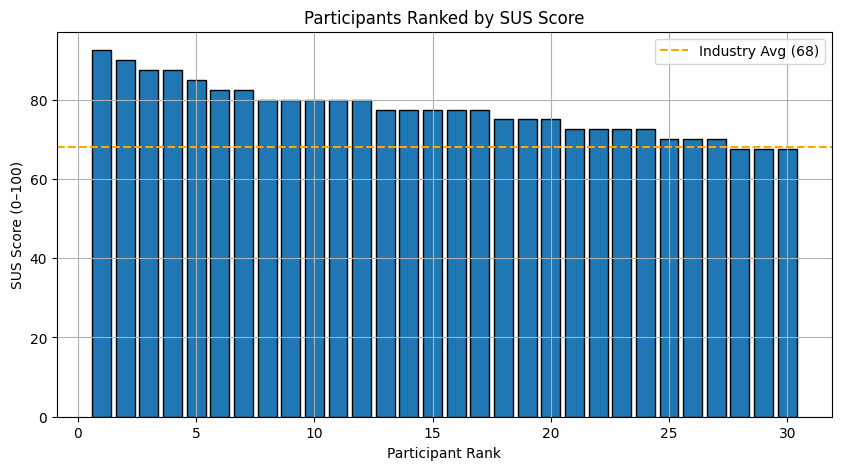

,Rank,SUS_Score
0,0,92.5
1,1,90.0
2,2,87.5
3,3,87.5
4,4,85.0
5,5,82.5
6,6,82.5
7,7,80.0
8,8,80.0
9,9,80.0


In [35]:
ranked = df.sort_values("SUS_Score", ascending=False).reset_index(drop=True)
plt.figure(figsize=(10,5))
plt.bar(ranked.index + 1, ranked["SUS_Score"], edgecolor="black")
plt.axhline(68, color="orange", linestyle="--", label="Industry Avg (68)")
plt.title("Participants Ranked by SUS Score")
plt.xlabel("Participant Rank")
plt.ylabel("SUS Score (0–100)")
plt.legend()
plt.show()

# Also show the ranked table
display(ranked[["SUS_Score"]].rename_axis("Rank").reset_index())


In [36]:
mean_sus = df["SUS_Score"].mean()
if mean_sus >= 85:
    band = "Excellent"
elif mean_sus >= 80:
    band = "Good–Excellent"
elif mean_sus >= 70:
    band = "Good"
elif mean_sus >= 68:
    band = "Above average"
elif mean_sus >= 50:
    band = "Below average"
else:
    band = "Poor"

print(f"Mean SUS: {mean_sus:.2f} → {band}")
print("Rule of thumb: ~68 = average usability; 85+ = excellent.")


Mean SUS: 77.42 → Good
Rule of thumb: ~68 = average usability; 85+ = excellent.
